# Restless multi-armed bandit

The restless or drifting bandits are a variant of dynamic multi-armed bandits in which reward probability changes continiously. A common description of the restless Bernoulli bandits are the following difference equations for the reward probabilities $p_{t,l}$ of each arm $l$

\begin{equation}
    \textrm{logit}(p_{t,l}) = \textrm{logit}(p_{t-1, l}) + \sqrt{\sigma} \cdot n_t 
\end{equation}
where $n_t \sim \mathcal{N}(0, 1)$ and $p_0 \sim U(0, 1)$. Here we will consider a same noise level on all arms set to $\sigma=0.01$.

Note than changes occur independently on different arms of the bandit. We will start with the generative process for the restless bandits.

In [1]:
import gc

import numpyro as npyro
import numpyro.distributions as dist

import jax.numpy as np
from jax.scipy.special import logit
from jax import random, lax, nn, ops

K = 3 
sigma = .1

def process(t, choices, probs, rng_key):
    
    lp = logit(probs)
    
    rng_key, _rng_key = random.split(rng_key)
    change = random.normal(_rng_key, shape=probs.shape)
    
    new_probs = nn.sigmoid(lp + sigma * change)
   
    rng_key, _rng_key = random.split(rng_key)
    outcomes = random.bernoulli(_rng_key, probs)
    
    N = choices.shape[0]
    
    return outcomes[None].repeat(N, 0), new_probs

def simulator(process, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, probs, choices = carry
        rng_key, _rng_key = random.split(rng_key)
        rng_key, _rng_key = random.split(rng_key)
        
        outcomes, probs = process(t, choices, probs, _rng_key)
        
        return (rng_key, probs, choices), {'rewards': outcomes, 'probs': probs}
    
    rng_key = random.PRNGKey(4904842)
    probs = random.uniform(rng_key, shape=(K,))
    choices = np.zeros(N, dtype=np.int32)
    
    _, sequence = lax.scan(sim_fn, (rng_key, probs, choices), np.arange(T))
    
    sequence['probs'] = np.concatenate([probs[None], sequence['probs']], 0)[:-1]
    
    return sequence

In [2]:
sequence = simulator(process)

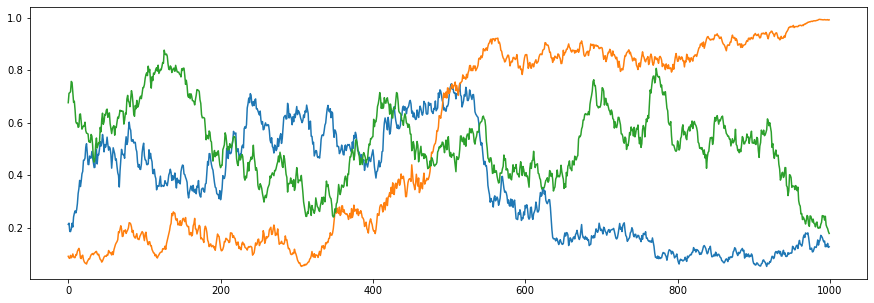

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(15, 5))
plt.plot(sequence['probs']);

Equivalent to the inference algorithm defined for piecewise-stationary bandits here we will assume that reward probability is defined only in $D$ descrete values  

$$ p \in P = \left\{\frac{1}{2D}, \ldots, 1-1/D\right\}$$

where $D$ denotes number of discrete values and $|P| = D$. And similarly for state transition probability

$$ \rho \in R = \left\{ \frac{1}{2M}, \ldots, 1-\frac{1}{M} \right\}, \qquad |R| = M$$

Hence we will infer time evolution of reward probabilities using hierarchical hidden markov model, with learnable change probabilities. 

In [4]:
from itertools import product

D = 10
args = [np.eye(D)] * K
tm1 = np.einsum('ij,kl,mn->ikmjln', *args).reshape(-1, D**K)

args = [(np.ones((D,D)) - np.eye(D))/(D-1)] * K
tm2 = np.einsum('ij,kl,mn->ikmjln', *args).reshape(-1, D**K)

pk_kj = np.stack([tm1, tm2], 0)

po_k = np.array(list(product(np.arange(1/(2*D), 1., 1/D), repeat=K)))
po_ks = np.where(np.eye(K, dtype=np.int32)[:, None], po_k, .5)

log_po_ks = np.log(po_ks)
log_1_po_ks = np.log(1 - po_ks)

M = 50
kappa = 1e-4
pr_r = (1 - kappa) * np.eye(M) + kappa * (np.diag(np.ones(M-1), 1) + np.diag(np.ones(M-1), -1))/2
pr_r = ops.index_update(pr_r, ops.index[[0, -1], [1, -2]], kappa)

rho = np.arange(1/(2*M), 1, 1/M)
stay = np.stack([1 - rho, rho], -1)
change = np.array([1., 0.])[None].repeat(M, -2)
pj_jr = np.stack([stay, change], -2)

def learning(outcomes, choices, priors):
    N = priors.shape[0]
    pred = np.einsum('iks,rij,rq,nrik->nqjs', pk_kj, pj_jr, pr_r, priors)
    
    o = outcomes[:, None]
    lklh = np.exp((log_po_ks[choices] * o + log_1_po_ks[choices] * (1 - o)).sum(-1))
    
    joint = lklh[:, None, None] * pred
    norm = joint.reshape(N, -1).sum(-1).reshape(N, 1, 1, 1)
    
    return joint/norm

def argmax_selection(beliefs, rng_key):    
    #argmax selection
    marg = np.einsum('n...k->nk', beliefs)
    mean_probs = np.einsum('nk,ko->no', marg, po_k)
    choices = mean_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

def thompson_selection(beliefs, rng_key):
    #Thompson sampling
    marg = np.einsum('n...k->nk', beliefs)
    sample = random.categorical(rng_key, np.log(marg))
    outcome_probs = po_k[sample] # map states to underlying outcome probabilities of different arms
    choices = outcome_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

def optimistic_selection(beliefs, rng_key):
    #Optimistic thompson sampling
    marg = np.einsum('n...k->nk', beliefs)
    sample = random.categorical(rng_key, np.log(marg))
    mean_probs = np.einsum('nk,ko->no', marg, po_k)
    outcome_probs = po_k[sample] # map states to underlying outcome probabilities of different arms
    outcome_probs = np.where(outcome_probs > mean_probs, outcome_probs, mean_probs)
    choices = outcome_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

H_ks = - np.sum(np.nan_to_num(log_po_ks) * po_ks, -1) \
       - np.sum(np.nan_to_num(log_1_po_ks) * (1 - po_ks), -1)

def efe_selection(beliefs, rng_key, gamma=10):
    # active inference
    marg = np.einsum('n...k->nk', beliefs)
    H_s = np.einsum('nk,ak->na', marg, H_ks)
    
    po_s = np.einsum('nk,ako->nao', marg, po_ks)
    log_po_s = np.nan_to_num(np.log(po_s))
    log_1_po_s = np.nan_to_num(np.log(1 - po_s))
    
    KL_s = np.sum(po_s * log_po_s + (1 - po_s) * log_1_po_s - (2 * po_s - 1), -1)
    
    G_s = KL_s #+ H_s
    
    choices = random.categorical(rng_key, - gamma * G_s) # sample choices
    return choices

def pfe_selection(beliefs, rng_key, gamma=10):
    # active inference
    marg = np.einsum('n...k->nk', beliefs)
    
    po_s = np.einsum('nk,ako->nao', marg, po_ks)
    log_po_s = np.nan_to_num(np.log(po_s))
    log_1_po_s = np.nan_to_num(np.log(1 - po_s))
    
    #KL_s = np.sum(po_s * log_po_s + (1 - po_s) * log_1_po_s - (2 * po_s - 1), -1)
    
    G_s = np.sum( - (2 * po_s - 1), -1)
    
    choices = random.categorical(rng_key, - gamma * G_s) # sample choices
    return choices

def simulator(process, learning, action_selection, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, probs, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = action_selection(prior, _rng_key)
        
        rng_key, _rng_key = random.split(rng_key)
        outcomes, probs = process(t, choices, probs, _rng_key)
        posterior = learning(outcomes, choices, prior)
                
        return (rng_key, probs, posterior), {'outcomes': outcomes, 
                                              'probs': probs, 
                                              'choices': choices,
                                              'beliefs': posterior}
    
    rng_key = random.PRNGKey(4904842)
    probs = random.uniform(rng_key, shape=(K,))
    args = [np.exp(- 1 * np.arange(M)), np.array([0., 1.])] + [np.ones(D)/D]*K
    prior = np.einsum('i,j,k,l,m->ijklm', *args).reshape(M, 2, -1)[None].repeat(N, 0)
    
    _, sequence = lax.scan(sim_fn, (rng_key, probs, prior), np.arange(T))
    
    sequence['probs'] = np.concatenate([probs[None], sequence['probs']], 0)[:-1]
    return sequence

In [5]:
N = 10
T = 1000

sequence_states = []
labels_states = []

sequence_states.append(simulator(process, learning, thompson_selection, N=N, T=T))
labels_states.append('thompson')
gc.collect()

sequence_states.append(simulator(process, learning, optimistic_selection, N=N, T=T))
labels_states.append('optimistic thompson')
gc.collect()

sequence_states.append(simulator(process, learning, pfe_selection, N=N, T=T))
labels_states.append('pfe')
gc.collect()

sequence_states.append(simulator(process, learning, argmax_selection, N=N, T=T))
labels_states.append('argmax')
gc.collect()

#sequence_states.append(simulator(process, learning, efe_selection, N=N, T=T))
#labels_states.append('efe')
#gc.collect()


0

In [6]:
from itertools import product

lamb = 0.92

D = 10
args = [np.eye(D)] * K
tm1 = np.einsum('ij,kl,mn->ikmjln', *args).reshape(-1, D**K)

args = [(np.ones((D,D)) - np.eye(D))/(D-1)] * K
tm2 = np.einsum('ij,kl,mn->ikmjln', *args).reshape(-1, D**K)

pk_kj = np.stack([tm1, tm2], 0)

po_k = np.array(list(product(np.arange(1/(2*D), 1., 1/D), repeat=K)))
po_ks = np.where(np.eye(K, dtype=np.int32)[:, None], po_k, .5)

log_po_ks = np.log(po_ks)
log_1_po_ks = np.log(1 - po_ks)

M = 50
kappa = 1e-4
pr_r = (1 - kappa) * np.eye(M) + kappa * (np.diag(np.ones(M-1), 1) + np.diag(np.ones(M-1), -1))/2
pr_r = ops.index_update(pr_r, ops.index[[0, -1], [1, -2]], kappa)

rho = np.arange(1/(2*M), 1, 1/M)
stay = np.stack([1 - rho, rho], -1)
change = np.array([1., 0.])[None].repeat(M, -2)
pj_jr = np.stack([stay, change], -2)

def parametric_learning(outcomes, choices, priors):
    post_p, post_alpha = priors
    N = choices.shape[0]
    #obs = np.zeros((N,K)) + 0.5
    #for n,k in enumerate(choices):
    #    obs = ops.index_update(obs, ops.index[n,k], outcomes.astype(np.int32)[n,k])
    #alpha_0 = 1 - obs + lamb * post_alpha[:,0] + 1 - lamb
    #alpha_1 = obs + lamb * post_alpha[:,1] + 1 - lamb
    alpha_0 = lamb * post_alpha[:,0] + 1 - lamb
    alpha_1 = lamb * post_alpha[:,1] + 1 - lamb
    obs = outcomes.astype(np.float32)
    for n,k in enumerate(choices):
            alpha_0 = ops.index_update(alpha_0, ops.index[n,k], \
                                       1 - obs[n,k] + alpha_0[n,k])
            alpha_1 = ops.index_update(alpha_1, ops.index[n,k], \
                                   obs[n,k] + alpha_1[n,k])
    q_alpha = np.array([alpha_0, alpha_1]).transpose((1,0,2))
        
    q_p = q_alpha
    q_p /= q_p.sum(axis=-2)[:,np.newaxis,:]
    
    return (q_p, q_alpha)

def parametric_argmax(beliefs, rng_key):
    #Argmax selection
    post_p, post_alpha = beliefs
    outcome_probs = post_p[:,1] # map states to underlying outcome probabilities of different arms
    choices = outcome_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

def parametric_thompson(beliefs, rng_key):
    #Thompson sampling
    post_p, post_alpha = beliefs
    sample = random.dirichlet(rng_key, post_alpha.transpose((0,2,1)))
    outcome_probs = sample[:,:,1] # map states to underlying outcome probabilities of different arms
    choices = outcome_probs.argmax(-1) # select choices with maximal outcome probability
    return choices

def parametric_optimistic(beliefs, rng_key):
    #Optimistic thompson sampling
    post_p, post_alpha = beliefs
    sample = random.dirichlet(rng_key, post_alpha.transpose((0,2,1)))
    outcome_probs = sample[:,:,1] # map states to underlying outcome probabilities of different arms
    mean_probs = post_p[:,1,:]
    outcome_probs = np.where(outcome_probs > mean_probs, outcome_probs, mean_probs)
    choices = outcome_probs.argmax(-1) # select choices with maximal outcome probability
    print(choices.shape)
    return choices

H_ks = - np.sum(np.nan_to_num(log_po_ks) * po_ks, -1) \
       - np.sum(np.nan_to_num(log_1_po_ks) * (1 - po_ks), -1)

def efe_selection(beliefs, rng_key, gamma=10):
    # active inference
    post_p, post_alpha = beliefs
    marg = post_p
    H_s = np.einsum('nk,ak->na', marg, H_ks)
    
    po_s = np.einsum('nk,ako->nao', marg, po_ks)
    log_po_s = np.nan_to_num(np.log(po_s))
    log_1_po_s = np.nan_to_num(np.log(1 - po_s))
    
    KL_s = np.sum(po_s * log_po_s + (1 - po_s) * log_1_po_s - (2 * po_s - 1), -1)
    
    G_s = KL_s #+ H_s
    
    choices = random.categorical(rng_key, - gamma * G_s) # sample choices
    return choices

def parametric_pfe(beliefs, rng_key, gamma=10):
    # active inference
    post_p, post_alpha = beliefs
    G_s = - (2 * post_p[:,1] - 1)
    
    choices = random.categorical(rng_key, - gamma * G_s) # sample choices
    return choices

def simulator(process, learning, action_selection, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, probs, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = action_selection(prior, _rng_key)
        
        rng_key, _rng_key = random.split(rng_key)
        outcomes, probs = process(t, choices, probs, _rng_key)
        posterior = parametric_learning(outcomes, choices, prior)
                
        return (rng_key, probs, posterior), {'outcomes': outcomes, 
                                              'probs': probs, 
                                              'choices': choices,
                                              'beliefs': posterior}
    
    rng_key = random.PRNGKey(4904842)
    probs = random.uniform(rng_key, shape=(K,))
    args = [np.exp(- 1 * np.arange(M)), np.array([0., 1.])] + [np.ones(D)/D]*K
    #prior = np.einsum('i,j,k,l,m->ijklm', *args).reshape(M, 2, -1)[None].repeat(N, 0)
    q_p_init = np.array([0.5,0.5], dtype=np.float32).tile((N,K,1)).transpose((0,2,1))
    q_alpha_init = np.array([1, 1], dtype=np.float32).tile((N,K,1)).transpose((0,2,1))
    prior = (q_p_init, q_alpha_init)
    _, sequence = lax.scan(sim_fn, (rng_key, probs, prior), np.arange(T))
    
    sequence['probs'] = np.concatenate([probs[None], sequence['probs']], 0)[:-1]
    return sequence

In [7]:
N = 10
T = 1000

sequence_parametric = []
labels_parametric = []

sequence_parametric.append(simulator(process, learning, parametric_thompson, N=N, T=T))
labels_parametric.append('parametric thompson')
gc.collect()

sequence_parametric.append(simulator(process, learning, parametric_optimistic, N=N, T=T))
labels_parametric.append('parametric optimistic thompson')
gc.collect()

sequence_parametric.append(simulator(process, learning, parametric_pfe, N=N, T=T))
labels_parametric.append('parametric pfe')
gc.collect()

sequence_parametric.append(simulator(process, learning, parametric_argmax, N=N, T=T))
labels_parametric.append('parametric argmax')
gc.collect()


(10,)


0

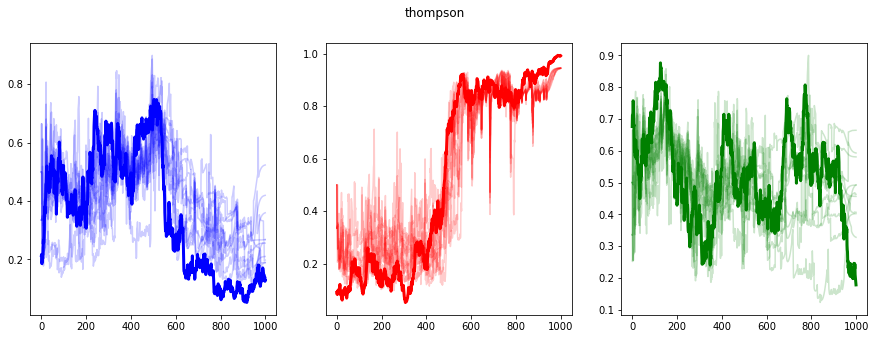

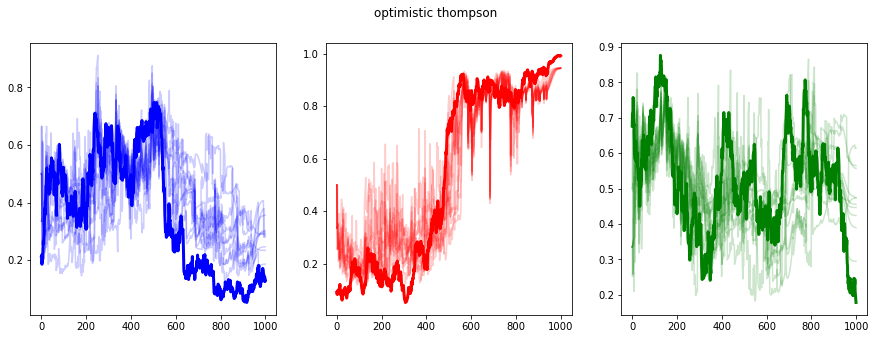

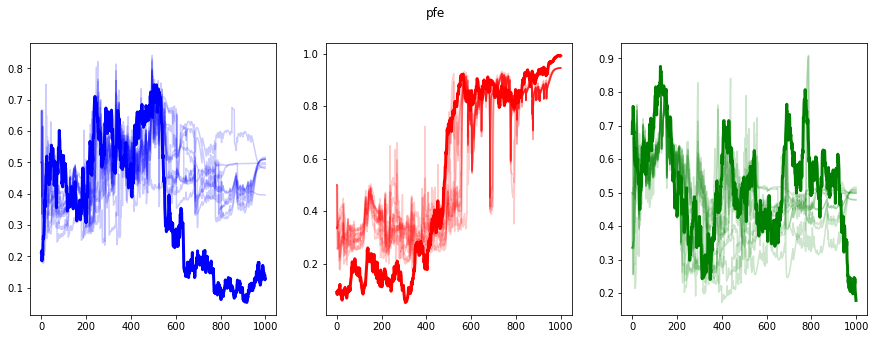

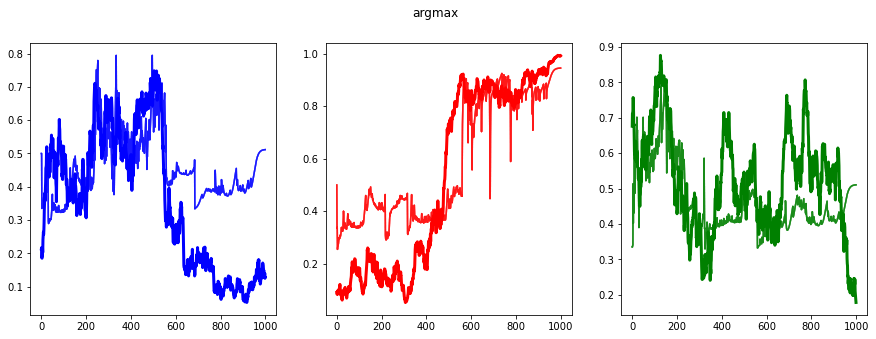

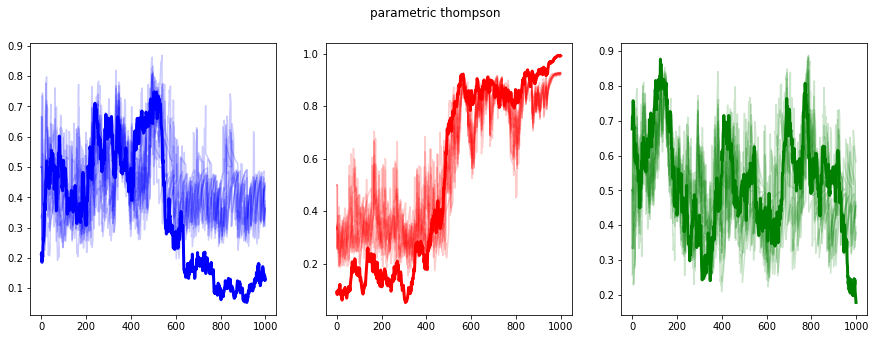

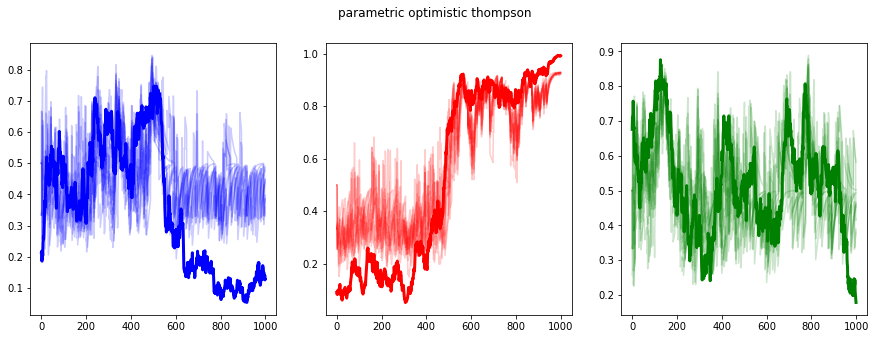

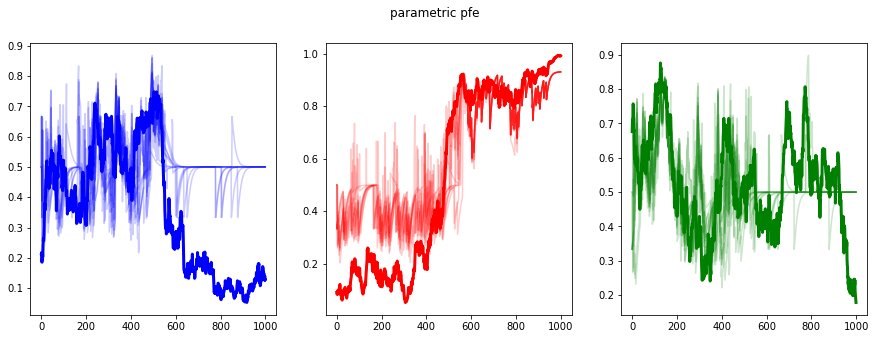

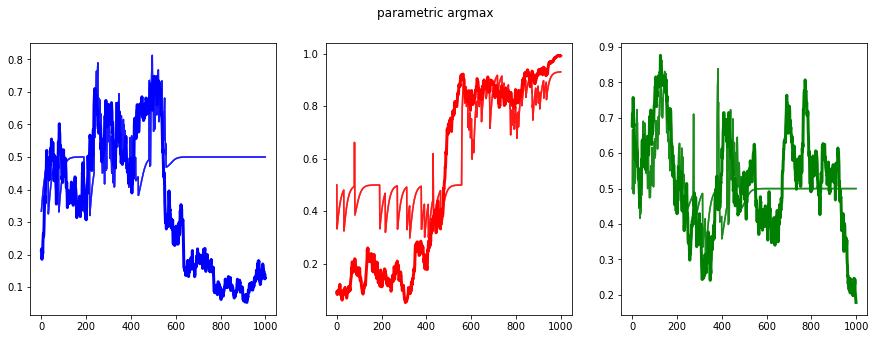

In [8]:
# plot beliefs which were inferred using discretized hidden states
for i,s in enumerate(sequence_states):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    post = s['beliefs']
    post_probs = np.einsum('tnk,lko->tnlo', post.sum(-2).sum(-2), po_ks)
    true_probs = s['probs']

    colours = ['b', 'r', 'g']
    for k in range(K):
        axes[k].plot(post_probs[..., k, k], c=colours[k], alpha=.2)
        axes[k].plot(true_probs[:, k], c=colours[k], lw=3)
    fig.suptitle(labels_states[i])
    plt.show()

# plot beliefs which were inferred using parametric learning
for i,s in enumerate(sequence_parametric):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    post = s['beliefs']
    post_probs = post[0]
    true_probs = s['probs']

    colours = ['b', 'r', 'g']
    for k in range(K):
        axes[k].plot(post_probs[..., 1, k], c=colours[k], alpha=.2)
        axes[k].plot(true_probs[:, k], c=colours[k], lw=3)
    fig.suptitle(labels_parametric[i])
    plt.show()
    


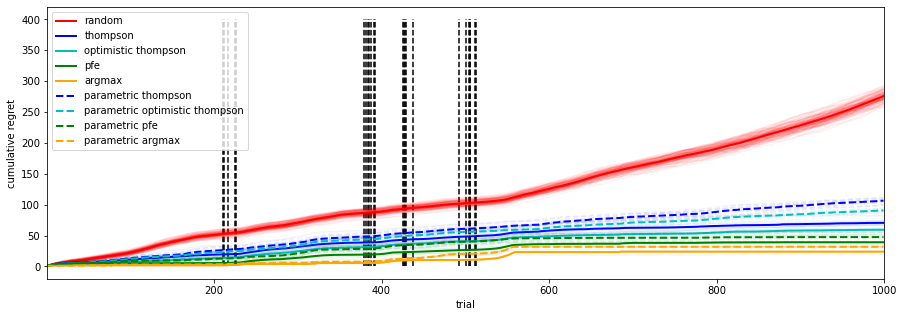

In [9]:
def calc_probs(choices):
    probs = np.stack([lax.index_take(true_probs, [np.arange(T), choices[:, n]], (0, 1)) for n in range(N)], 0)
    return probs

states_probs = [calc_probs(s['choices']) for s in sequence_states]
parametric_probs = [calc_probs(s['choices']) for s in sequence_parametric]

max_probs = lax.index_take(true_probs, [np.arange(T), true_probs.argmax(-1)], (0, 1))

n_smpl = 100
random_choices = random.categorical(random.PRNGKey(547890), np.zeros(K), shape=(T, n_smpl))
random_probs = np.stack([lax.index_take(true_probs, [np.arange(T), random_choices[:, n]], (0, 1)) for n in range(n_smpl)], 0)


fig, axes = plt.subplots(1, 1, figsize=(15, 5))

regret = np.cumsum(max_probs - random_probs, -1).T
plt.plot(regret, 'r', alpha=.05);
plt.plot(regret.mean(-1), 'r', label='random', lw=2)

line_colors = ['b', 'c', 'g', 'orange', 'purple']

for i,probs in enumerate(states_probs):
    regret = np.cumsum(max_probs - probs, -1).T
    plt.plot(regret, line_colors[i], alpha=.05);
    plt.plot(regret.mean(-1), line_colors[i], label=labels_states[i], lw=2)
    
for i,probs in enumerate(parametric_probs):
    regret = np.cumsum(max_probs - probs, -1).T
    plt.plot(regret, line_colors[i], linestyle='--', alpha=.05);
    plt.plot(regret.mean(-1), line_colors[i], linestyle='--', label=labels_parametric[i], lw=2)

plt.xlim(1, T)
plt.xlabel('trial')
plt.ylabel('cumulative regret')
plt.legend()

changes = np.concatenate([np.zeros(1), np.abs(np.diff(true_probs.argmax(-1)))], -1)
plt.vlines(np.nonzero(changes), 0, 400, linestyle='--')

fig.savefig('cum_reg_restless.png', dpi=300)

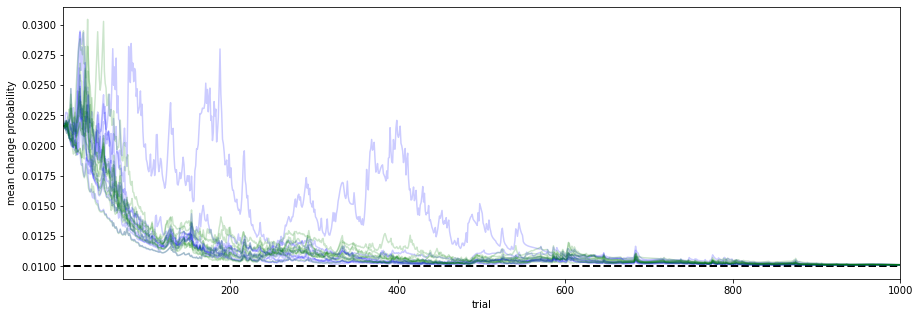

In [10]:
post = [sequence_states[0]['beliefs'], sequence_states[1]['beliefs']]

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

for p, c in zip(post, ['b', 'g']):
    marg = p.reshape(T, N, M, -1).sum(-1)
    prob = np.sum(marg * rho, -1)
    
    plt.plot(prob, c, alpha=.2)

plt.hlines(.01, 1, T, 'k', lw=2, linestyle='--')
plt.xlabel('trial')
plt.ylabel('mean change probability')
plt.xlim([1, T])
fig.savefig('change_prob_restless.png', dpi=300)